### Load packages

In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense

import tensorflow.keras.backend as K

### Import ZLP data

In [229]:
for file_name in os.listdir('Data/'):
    if fnmatch.fnmatch(file_name, '*.dat'):
        print(file_name)

ZLP_200 keV_2ms_008.dat
ZLP_200 keV_2ms_009.dat
01.dat
ZLP_200 keV_2ms_007.dat
ZLP_200 keV_2ms_006.dat
ZLP_200 keV_2ms_010.dat
ZLP_200 keV_2ms_004.dat
ZLP_200 keV_2ms_005.dat
ZLP_200 keV_2ms_002.dat
ZLP_200 keV_2ms_003.dat


In [230]:
%run EELS-ZLP.py


 ***************************************************** 



## Neural Network

### Prepare trainings data 

In [231]:
N_train = 10000
N_test = 2000

def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

def prepare_single_data():
    '''Training set of many copies of one single spectrum'''
    y_train = EELSData_intensity_zlp_2
    x_train = EELSData_Eloss_2


    vector = np.ones(N_train)
    x_train =  np.swapaxes( (np.reshape(vector,[N_train,1, 1]) * x_train), 1, 2)
    x_val = x_train[N_train-N_test:]
    x_train = x_train[:(N_train-N_test)]
    
    y_train = np.swapaxes( (np.reshape(vector,[N_train,1, 1]) * y_train), 1, 2)
    ### Normalization
    y_max = np.max(y_train, axis=1)
    y_train_norm = np.divide(y_train, y_max[:, None, :])
    y_train_norm = np.squeeze(y_train_norm, axis=2)
    y_val = y_train_norm[N_train-N_test:]
    y_train = y_train_norm[:(N_train-N_test)]

    y_train = y_train.flatten()
    x_train = x_train.flatten()
    y_val = y_val.flatten()
    x_val = x_val.flatten()
    
    x_train, y_train, x_val, y_val = np.around(x_train, 4), np.around(y_train, 4), np.around(x_val, 4), np.around(y_val, 4)
    return x_train, y_train, x_val, y_val

x_train, y_train_norm, x_val, y_val = prepare_single_data()



In [232]:
def make_model():
    model = tf.keras.Sequential()
    model.add(Dense(5, activation='relu', input_shape=(1,)))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1))
    return model

    
def custom_cost_single(y_true, y_pred):
    '''Chi square function'''
    sigma = std(y_train_norm)
    return tf.reduce_mean(tf.square((y_true-y_pred)/sigma))

K.clear_session()
model = make_model()

### Show sample of training data

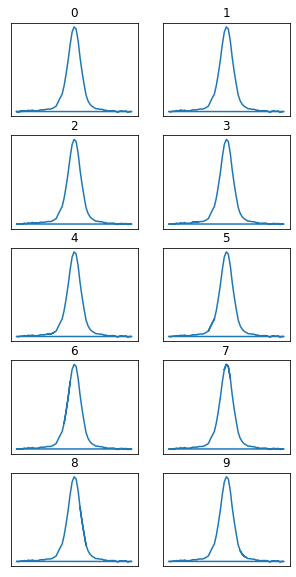

In [233]:
plt.figure(figsize=(5,10))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.plot(x_train[i*63 : (i+1)*63], y_train_norm[i*63 :(i+1)*63])
    plt.title(i)
plt.show()

## Build architecture & start training

In [234]:
mode = 'Single'
epochsize = 50
if mode == 'Single':

    print ("********** Prepare training on single ZLP spectrum... ********** ")
    x_train, y_train, x_val, y_val = prepare_single_data()
    
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(loss='mse',
              optimizer=sgd,
              metrics=[custom_cost_single])
    
    loss = model.fit(x_train, y_train, batch_size = 2000, epochs=epochsize)
    test = model.evaluate(x_val, y_val)
    
elif mode == 'Mixture':
    print ("********** Praining on mixed ZLP spectra... **********")
    ### This is not useful yet as the five different input spectra we now have are of different length 
    ### and should therefore be trained on different models. Let's wait for more (full) spectra before we 
    ### start training on a mixed batch.
    x_train, y_train, y_std = prepare_mixed_data(samplenumber)
    loss = model.fit(x_train_mix, y_train_norm_mix, batch_size = 5, epochs=10)
    
else:
    print("No mode specified. Training not possible.")


********** Prepare training on single ZLP spectrum... ********** 
Epoch 1/50
472000/472000 [==============================] - 0s 1us/sample - loss: 0.0685 - custom_cost_single: 0.9362
Epoch 2/50
472000/472000 [==============================] - 0s 1us/sample - loss: 0.0652 - custom_cost_single: 0.8908
Epoch 3/50
472000/472000 [==============================] - 0s 1us/sample - loss: 0.0618 - custom_cost_single: 0.8439
Epoch 4/50
472000/472000 [==============================] - 0s 1us/sample - loss: 0.0570 - custom_cost_single: 0.7789
Epoch 5/50
472000/472000 [==============================] - 0s 1us/sample - loss: 0.0509 - custom_cost_single: 0.6951
Epoch 6/50
472000/472000 [==============================] - 0s 1us/sample - loss: 0.0441 - custom_cost_single: 0.6026
Epoch 7/50
472000/472000 [==============================] - 0s 1us/sample - loss: 0.0379 - custom_cost_single: 0.5179
Epoch 8/50
472000/472000 [==============================] - 0s 1us/sample - loss: 0.0327 - custom_cost_singl

### Store data

In [235]:
hist_df = pd.DataFrame(loss.history) 
#save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
    
loss_data = pd.read_csv('history.csv')['loss']
chi_data = pd.read_csv('history.csv')['custom_cost_single']

### Plot outputs

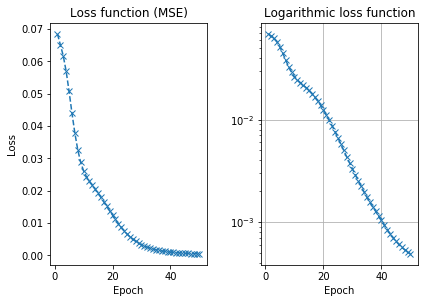

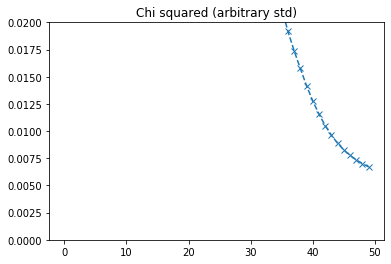

In [238]:
epochsize = 50

plt.figure()
plt.subplot(121)
plt.plot(np.linspace(1,epochsize,epochsize), loss_data,'x--')
#plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss function (MSE)')

plt.subplot(122)
plt.plot(np.linspace(1,epochsize,epochsize), loss_data,'x--')
plt.yscale('log')
plt.grid(True)
plt.xlabel('Epoch')
plt.title('Logarithmic loss function')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

plt.plot(chi_data, 'x--')
plt.title('Chi squared (arbitrary std)')
plt.ylim([0,0.02])
plt.show()